# Convolutional Neural Network

In this tutorial, we show how to train a Convolutional Neural Network using MXNet on a popular hand written digit data.

convolutional neural networks [(LeCun, 1989)](https://www.researchgate.net/profile/Yann_Lecun/publication/2453996_Convolutional_Networks_for_Images_Speech_and_Time-Series/links/0deec519dfa2325502000000.pdf) or CNNs are specially designed for processing data that is correlated along some directions. For example, time series data has temporal information along the time dimension, while image data has spatial information along different axis. These relation would be ignored in fully connected layers that view each time step (for time series) or pixel (for images) as independent features. As a consequence, CNN employs a mathematical operation called
*convolution* that aim to improve this drawback by using a more structural weight $W$.

## The MNIST Data
We conduct CNN on one of the most classic machine learning data: MNIST. It is a simple computer vision dataset that consists of images for handwritten digits recognition. Each image in this dataset has been resized into 28x28 with grayscale value between 0 and 254. The following codes download and load the images and the according labels into numpy. In this tutorial, we're going to train a model to look at images and predict what digits they are. 

MNIST is hosted on Yann LeCun's website. To access the data for the first time, we start with the following code that downloads and reads in the data automatically into numpy:

In [1]:
import numpy as np
import os
import urllib
import gzip
import struct
def download_data(url, force_download=True): 
    fname = url.split("/")[-1]
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname

def read_data(label_url, image_url):
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(
    path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(
    path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')

The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation). It's important in machine learning that we evaluate the performance of our learnt model on data not used in training to avoid overfitting only on the training data. 

Every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. We'll call the images "x" and the labels "y". Both the training set and test set contain images and their corresponding labels; for example the training images are mnist.train.images and the training labels are mnist.train.labels.
We plot the first 10 images and print their labels.

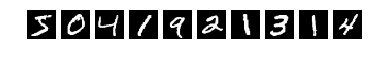

label: [5 0 4 1 9 2 1 3 1 4]


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(train_img[i], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))

Next we create data iterators for MXNet. The data iterator, which is similar the iterator, returns a batch of data in each <font color='red'>next()</font> call. A batch contains several images with its according labels. These images are stored in a 4-D matrix with shape <font color='red'>(batch_size, num_channels, width, height)</font>. For the MNIST dataset, there is only one color channel, and both width and height are 28. In addition, we often shuffle the images used for training, which accelerates the training progress.

In [3]:
import mxnet as mx

def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)


# Model
The major difference of CNN and MLP is that it leverages the following ideas that not only improve the system efficiency and footprint, but also take care of the correlation along data axis.

- *Sparse interactions*: each layer is no longer *fully connected*. This is accomplished by making the kernel smaller than the input, which will be illustrated in the convolution operatioin section.

- *Parameter sharing*: CNN may use the same parameter for more than one function in a model. 

## The Convolution Operation
In CNN, we usually refer the weight as the kernel (related to the terminology in convolution of Mathematical concept). In the following figure, we show what convolution operation does is to take each position of a same sized sub-matrix of the input data, and do inner product with the same kernel matrix (parameter sharing). 

From the operation, we can see that each member of the kernel is used at every position of the input (sub-matrix by sub-matrix). The parameter sharing used by the convolution operation means that rather than learning a separate set of parameters for every location, we learn only one set.

![alt text](conv.png)

We can also have multiple feature maps, each with their own weight matrices, to capture different features: 
![alt text](filters.png)



## Pooling
Besides the convolutional layer, another major change of the convolutional neural network is the adding of pooling layers. A pooling layer reduce a $n\times m$ (often called kernal size) image patch into a single value to make the network less sensitive to the spatial location.
![alt text](pooling.png)


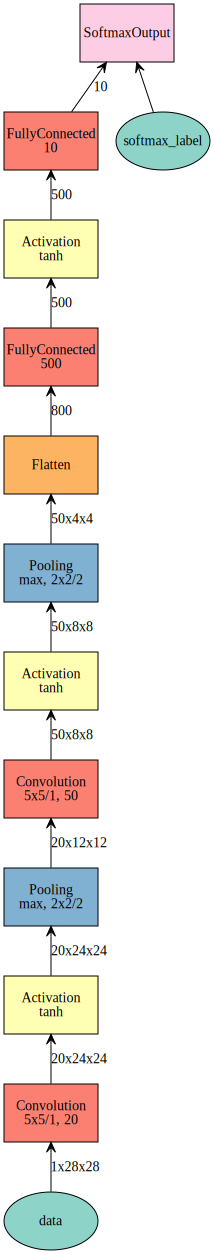

In [4]:
shape = {"data" : (batch_size, 1, 28, 28)}
data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
mx.viz.plot_network(symbol=lenet, shape=shape)

In [5]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
model = mx.model.FeedForward(
    #ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 10,     
    learning_rate = 0.1)
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
) 
assert model.score(val_iter) > 0.98, "Low validation accuracy."

[Deprecation Warning] mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.


In [6]:
model.score(val_iter)

0.9867

Note that, with the same hyper-parameters, LeNet achieves 98.7% validation accuracy, which improves on the previous multilayer perceptron accuracy of 96.6%.

Because we rewrite the model parameters in mod, now we can try the previous digit recognition box again to check if or not the new CNN model improves the classification accuracy.

